In [1]:
%reset 
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import seaborn as sns


from process_lfps import butter_bandpass_filter, create_data_segments

sns.set(font_scale=2,style='whitegrid') 
pd.set_option('max_colwidth',100)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Plotting Place Fields on Linear Track

In [2]:
datapath = 'python_data_lintrack/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]

In [3]:
files

['posdf_day1_epoch2.csv', 'spikesdf_day1_epoch2.csv']

In [4]:
posdf = pd.read_csv(os.path.join(datapath,'posdf_day1_epoch2.csv'))
spikesdf = pd.read_csv(os.path.join(datapath,'spikesdf_day1_epoch2.csv'))

In [5]:
spikesdf['posindex_0ind'] = spikesdf[['posindex']] - 1

In [6]:
spikesdf

,spike_ts,x,y,hdir,posindex,cell_id,cell_type,posindex_0ind
0,3902.7383,103.35,133.90,0.625485,531,HPa_CA1_day1_epoch2_tet1_unitnum1,CA1Pyr,530
1,3905.7398,105.95,135.20,0.463648,621,HPa_CA1_day1_epoch2_tet1_unitnum1,CA1Pyr,620
2,3911.1145,109.85,100.10,-2.587285,783,HPa_CA1_day1_epoch2_tet1_unitnum1,CA1Pyr,782
3,3972.4770,108.55,124.80,0.039979,2622,HPa_CA1_day1_epoch2_tet1_unitnum1,CA1Pyr,2621
4,3972.4809,108.55,124.80,0.039979,2622,HPa_CA1_day1_epoch2_tet1_unitnum1,CA1Pyr,2621
...,...,...,...,...,...,...,...,...
41816,5029.8387,102.05,70.85,-1.642104,34317,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,34316
41817,5029.8457,102.05,70.85,-1.642104,34317,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,34316
41818,5033.2821,102.05,70.20,-1.639653,34420,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,34419
41819,5033.3140,102.70,70.20,-1.605265,34421,HPa_iCA1_day1_epoch2_tet14_unitnum1,iCA1Pyrpr,34420


In [7]:
posdf = posdf.dropna()

In [8]:
cell_labels = list(set(spikesdf['cell_id'].to_list()))

In [117]:
subcell = spikesdf[spikesdf['cell_id']==cell_labels[15]]

locinds = list(set(posdf.index) & set(subcell['posindex_0ind']))
locinds = sorted(locinds)
locinds = locinds[:-1]

x_spikes = posdf['x'].iloc[locinds]
y_spikes = posdf['y'].iloc[locinds]

In [118]:
set(subcell['cell_type'].to_list())

{'iCA1Pyrpr'}

error: a ratio exceeds 1


(0.0, 139.52575)

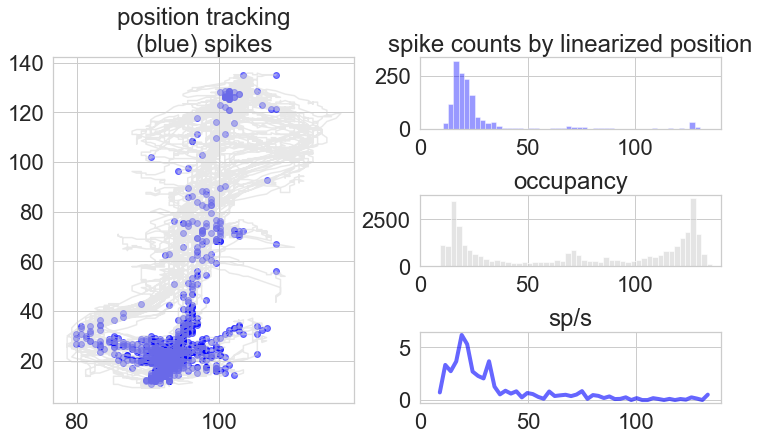

In [119]:
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'middle right'],
                               ['left', 'lower right']
                              ],
                              figsize=(10, 6), constrained_layout=True)


axd['left'].plot(posdf['x'],posdf['y'],color='lightgrey',alpha=0.5)
axd['left'].scatter(x_spikes,y_spikes,color='blue',alpha=0.5)
axd['left'].set_title('position tracking' + '\n' + '(blue) spikes')

sp_per_bin = axd['upper right'].hist(y_spikes,bins=50,alpha=0.4,color='blue')
axd['upper right'].set_title('spike counts by linearized position')
axd['upper right'].set_xlim(0,140)


occupancy_per_bin = axd['middle right'].hist(posdf['y'],bins=50,alpha=0.6,color='lightgrey')
axd['middle right'].set_title('occupancy')
axd['middle right'].set_xlim(0,140)

norm_spikes_per_bin = sp_per_bin[0] / (occupancy_per_bin[0] * np.median(np.diff(posdf['time'].values))) 

if np.where(sp_per_bin[0] / occupancy_per_bin[0] > 1):

    print('error: a ratio exceeds 1')

bin_edges = occupancy_per_bin[1]
axd['lower right'].plot(bin_edges[:-1],norm_spikes_per_bin,alpha=0.6,linewidth=4,color='blue')
axd['lower right'].set_title('sp/s')
axd['lower right'].set_xlim(0,)


Now, I: need to apply the cutoffs that people use to determine the time stamps corresponding to entrance into and exit from the place field for each cell. Storage options: 

- separate df per unique cell
- single df, with column labels indicating cell identity, entrance time, exit time

Currently leaning towards the second, to keep all the data for each day/epoch within a single folder?

- smooth fields first 
- find the local maximum (maxima)
- find the bins at which the frate decays to less than 10% of the maximum


Notes from Buzsaki Lab code: 
- minimum peak rate set at 2 Hz
- percent change between peak rate and start/end of field (set to 15%)
- remove field peaks with standard deviation > mean frate (unreliable)
- find center of mass: 
    
      while sum(meanRates(i,startfield:stopfield)) - sum(meanRates(i,startfield:com)) > sum(meanRates(i,startfield:stopfield))./2: 
            fields{i}{fieldCount}.COM = com;
            com = com + 1 
      end
      fieldCount = fieldCount + 1

In [120]:
#smoothing

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

s=norm_spikes_per_bin
sm = gaussian_filter1d(s, 2)

if np.mean(sm) <=3:
    
    thresh_peak = 2 #Hz, min frate to be considered a peak of field
    thresh_pct = 0.15 #percent of edge relative to max peak
    
    

    #find the max peak
    peaks, _ = find_peaks(sm, height = thresh_peak)
    vanillapeaks = np.where(sm == max(sm))
    locpeaks = np.hstack((vanillapeaks[0], peaks))
    peaks = np.array(sorted(list(set(locpeaks))))

    
    if len(peaks) > 0:

        maxpeak = np.where(sm == sm[peaks].max())

        if sm[maxpeak[0]] < thresh_peak:
            print('peak too small')

        #use the peaks of the second derivative to find the right and left edges of the field
        dd = np.diff(np.diff(sm)) #second derivative of the position
        mean_dd = np.mean(dd)
        std_dd = np.std(dd)

        thresh_dd_peaks = mean_dd + std_dd - 0.01 #hacky

        locpeakdd, _ = find_peaks(dd,height = thresh_dd_peaks)
        vanillamaxdd = np.where(dd == max(dd))
        locmaxdd = np.hstack((vanillamaxdd[0], locpeakdd))
        locmaxdd = np.array(sorted(list(set(locmaxdd))))



        distances = locmaxdd - maxpeak

        #find the left edge of the field
        negdists = np.where(distances < 0)[1]
        left_edge = locmaxdd[negdists]
        
        if len(left_edge) > 1:
            left_edge = left_edge[np.where(left_edge == min(abs(left_edge)))][0]
            
            while (sm[left_edge]/sm[maxpeak] > thresh_pct) & (left_edge > 0):
                
                left_edge -= 1
                
            while (sm[left_edge]/sm[maxpeak] < thresh_pct) & (left_edge > 0):
                
                left_edge+=1

        elif len(left_edge) == 1:
            left_edge = left_edge[0]
            
            while (sm[left_edge]/sm[maxpeak] > thresh_pct) & (left_edge > 0):
                
                left_edge -= 1
                
            while (sm[left_edge]/sm[maxpeak] < thresh_pct) & (left_edge > 0):
                
                left_edge+=1
            
        elif len(left_edge) < 1:
            #in casese of a field that peaks right at the left edge of the linear maze
            left_edge = 0

        #find the right edge of the field
        posdists = np.where(distances > 0)[1]
        right_edge = locmaxdd[posdists]
        
        if len(right_edge) > 1:
            right_edge = right_edge[np.where(right_edge == min(right_edge))][0]
            
            while (sm[right_edge]/sm[maxpeak] > thresh_pct) & (right_edge < len(sm) - 1):
                
                right_edge += 1
                
            while (sm[right_edge]/sm[maxpeak] < thresh_pct) & (right_edge < len(sm) - 1):
                
                right_edge-=1
                    
        elif len(right_edge) == 1:
            right_edge = right_edge[0]
            
            
            while (sm[right_edge]/sm[maxpeak] > thresh_pct) & (right_edge < len(sm) - 1):
                
                right_edge += 1
                
            while (sm[right_edge]/sm[maxpeak] < thresh_pct) & (right_edge < len(sm) - 1):
                
                right_edge-=1
            
        elif len(right_edge) < 1:
            #in casese of a field that peaks right at the right edge of the linear maze
            right_edge = len(sm)-1 #last pos bin
            
        
        

In [102]:
left_edge,maxpeak,right_edge

(0, (array([5]),), 13)

In [103]:
sm[maxpeak] * .15

array([0.33197991])

In [104]:
sm[maxpeak]

array([2.21319939])

In [105]:
sm[right_edge]/sm[maxpeak],sm[left_edge]/sm[maxpeak]

(array([0.17716907]), array([0.42541558]))

In [106]:
sm[left_edge]

0.9415295137772128

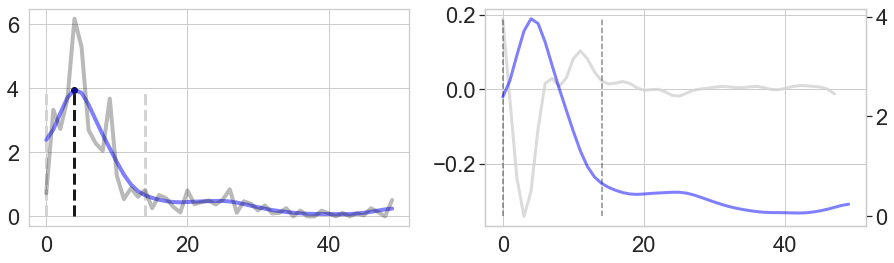

In [121]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

ax[0].plot(sm,linewidth=4,alpha=0.5,color='blue')
ax[0].plot(s,linewidth=4,alpha=0.3,color='k')
ax[0].scatter(peaks, sm[peaks],color='k')
ax[0].vlines(x = maxpeak, ymin = 0, ymax = max(sm), color = 'k', linewidth = 3, linestyle = "--")
ax[0].vlines(x = [left_edge, right_edge], ymin = 0, ymax = max(sm), color = 'lightgrey', linewidth = 3, linestyle = "--")
    
ax[1].plot(dd,color='lightgrey',alpha=0.8,linewidth=3) 
ax__ = ax[1].twinx()
ax__.grid(False)
ax__.plot(sm,color='blue',alpha=0.5,linewidth=3)

ax__.vlines(x = [left_edge, right_edge], ymin = 0, ymax = max(sm),color='k',alpha=0.5,linestyle="--")
    

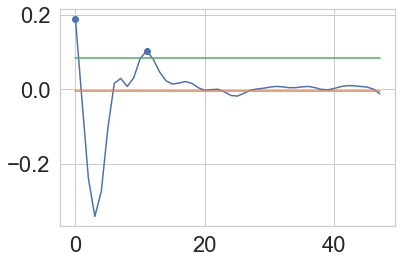

In [122]:
plt.plot(dd)
plt.scatter(locmaxdd,dd[locmaxdd])
plt.plot(np.repeat(np.mean(dd),len(dd)))
plt.plot(np.repeat(np.std(dd),len(dd)))

In [ ]:
# now that I have the left and right edges of the place field, need to use these y coordinate position indices
# to find all the times that the rat crosses those indices